# Naive Bayes for Image Data

## Preliminaries

### Imports

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB,BernoulliNB

from scipy import ndimage

%matplotlib inline
import gzip

import sys
sys.path.append("../..")
from E4525_ML import mnist
from E4525_ML import plots

### Data

In [2]:
data_dir=r"../../raw/mnist/"

In [3]:
    images_filename=data_dir+"train-images-idx3-ubyte.gz"
    labels_filename=data_dir+"train-labels-idx1-ubyte.gz"

    test_images_filename=data_dir+"t10k-images-idx3-ubyte.gz"
    test_labels_filename=data_dir+"t10k-labels-idx1-ubyte.gz"

    images=mnist.read_images(images_filename)
    X=images
    Y=mnist.read_labels(labels_filename)
    
    print(X.shape,Y.shape)

(60000, 28, 28) (60000,)


In [4]:
nimages=X.shape[0]
nrows=X.shape[1]
ncols=X.shape[2]
print(nimages,nrows,ncols)

60000 28 28


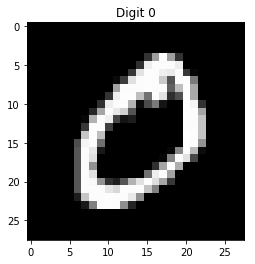

In [5]:
label=int(Y[1])
plt.title('Digit {0}'.format(label))
plt.imshow(X[1], cmap='gray')

##  Gaussian Naive Bayes Classifier

As usual for $(R,C)$ greay scale images we linearize to that 
$$
    X_{i,r*C+c} = F_{i,r,c}
$$
where $d=r*C+c$, and $d=1,\cdots,D= RC$ represent each one of the pixels on the image.

We will first assume that pixel intensities are have a **Gaussian** distribution
$$
    P(X_i) = \prod_{d=1}^D N(X_{i,d}; \mu_d,\sigma^2_d)
$$
where $\mu_d$ and $\sigma^2_d$ will be learned from the training set, **independently** for each pixel d.


In [6]:
X=X.reshape((nimages,-1))
print(X.shape,Y.shape)
    

(60000, 784) (60000,)


In [7]:
model=GaussianNB()

In [8]:
model.fit(X,Y)

GaussianNB(priors=None)

In [9]:
images_test=mnist.read_images(test_images_filename)
labels_test=mnist.read_labels(test_labels_filename)
X_test=images_test
Y_test=labels_test

Model makes some mistakes

In [10]:
print(model.predict(X_test[0].reshape(1,-1)),Y_test[0])

[9] 7


Accuracy is pretty low.

In [11]:
Y_predicted=model.predict(X_test.reshape((-1,nrows*ncols)))
print("accuracy",np.mean(Y_predicted==Y_test))

accuracy 0.5558


We make all sorts of mistakes

In [12]:
classes=np.unique(Y)

Confusion matrix, without normalization
[[ 870    0    3    5    2    5   31    1   35   28]
 [   0 1079    2    1    0    0   10    0   38    5]
 [  79   25  266   91    5    2  269    4  271   20]
 [  32   39    6  353    2    3   51    8  409  107]
 [  19    2    5    4  168    7   63    7  210  497]
 [  71   25    1   20    3   44   40    2  586  100]
 [  12   12    3    1    1    7  895    0   26    1]
 [   0   15    2   10    5    1    5  280   39  671]
 [  13   72    3    7    3   11   12    4  648  201]
 [   5    7    3    6    1    0    1   13   18  955]]


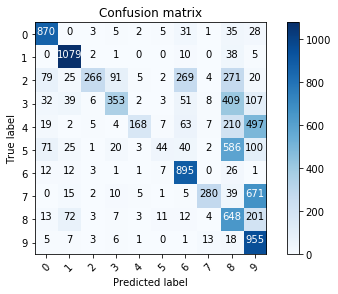

In [13]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_predicted)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)

## Bernoulli Naive  Bayes Classifier

Pixels on the image are on the range (0,1).
Lot of the pixes on the image are at the extremes 0 or 1. A Gaussian distribution  is not an appropiate assumption there.

If we assume that the pixels are distributed as as $k/N$ where $k$ has a multinomial distribution, we can use a Bernoulli distribution (bounded between
zero and one)
$$
    P(X_{i}|y_i)= \prod_{d=1}^D P(x_{i,d}|y_i) x_{i,d} 
                              + (1-P(x_{i,d}|y_i)(1-x_{i,d})
 $$
 
 Where we will use Laplace smoothing to estimae the probabilities
 $$
     P(x_{i,d}|y_i) = \frac{\hat{N}_k+\alpha}{\hat{N}+\alpha K}
 $$
 where $K$ is the number of values the label $y_i$ can take

In [14]:
ber_model=BernoulliNB(alpha=1)

In [15]:
ber_model.fit(X,Y)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

Bernoulli's Naive Bayes has has much better accuracy that Gaussian Naive Bayes
for this particular problem

In [16]:
Y_predicted=ber_model.predict(X_test.reshape((-1,nrows*ncols)))
print("accuracy",np.mean(Y_predicted==Y_test))

accuracy 0.8413


Confusion matrix, without normalization
[[ 887    0    4    7    2   41   16    1   22    0]
 [   0 1085   10    5    0    9    6    0   19    1]
 [  19    8  852   29   17    4   32   14   55    2]
 [   5   15   34  844    0   13    9   15   49   26]
 [   2    6    4    0  795    4   21    1   23  126]
 [  23   12    7  129   30  627   16    8   21   19]
 [  18   18   15    2   13   35  851    0    6    0]
 [   1   24   14    4   15    0    0  871   27   72]
 [  16   23   13   76   17   22    7    6  758   36]
 [   9   13    5    9   74    8    0   24   24  843]]


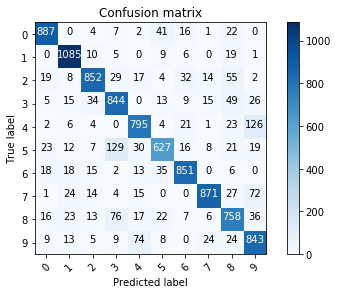

In [17]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_predicted)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)

### Visualize loadings

In [18]:
loadings=ber_model.feature_log_prob_.reshape(-1,nrows,ncols)
loadings.shape

(10, 28, 28)

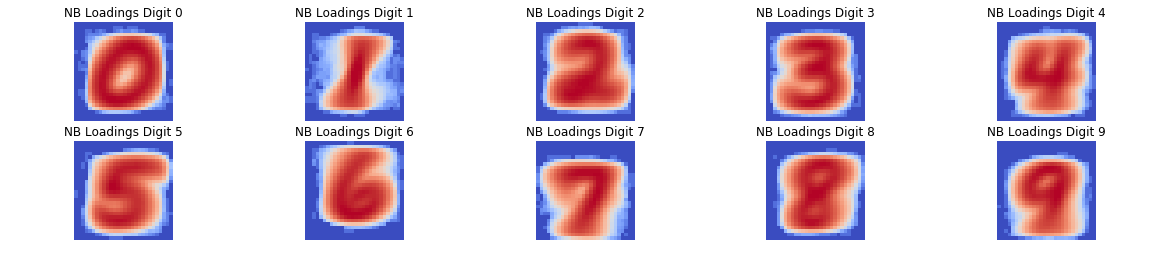

In [19]:
# Two subplots, unpack the axes array immediately
f, axes = plt.subplots(2, 5, sharey=True,figsize=(20,4))
for d,ax in enumerate(axes.ravel()):
    ax.set_title('NB Loadings Digit {0}'.format(d))
    ax.imshow(loadings[d], cmap='coolwarm')
    ax.axis("off")

### Save model for Reuse

In [20]:
import os
model_dir="..\..\data\models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [21]:
import pickle
model_filename=model_dir+"/MNIST_NaiveBayes.p"
file=open(model_filename,"wb")
pickle.dump(ber_model,file)

## Off-Center Images

We would like our classifier to be invariant to shifts on the image position

In [22]:
def roll(image,max_x=4,max_y=4):
    shiftx=np.random.randint(-max_x,max_x)
    shifty=np.random.randint(-max_y,max_y)
    image=np.roll(image,[shiftx,shifty],[0,1])
    return image

In [23]:
idx=1

In [24]:
img1=roll(images_test[idx])


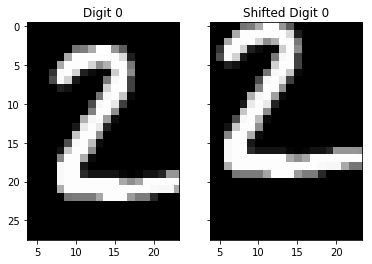

In [25]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Digit {0}'.format(label))
ax1.imshow(images_test[idx], cmap='gray')
ax2.set_title('Shifted Digit {0}'.format(label))
ax2.imshow(img1, cmap='gray')


In [26]:
shifted_images_test=np.empty_like(images_test)
for i in range(len(images_test)):
    shifted_images_test[i]=roll(images_test[i])
    

Let's see how well we can predict now

In [27]:
nimages=shifted_images_test.shape[0]
X_test=shifted_images_test.reshape((nimages,-1))
print("predicting...",end=" ")
Y_predicted=ber_model.predict(X_test)
print("Done.")

predicting... Done.


Much Worse

In [28]:
accuracy=(Y_predicted==Y_test).sum() / len(Y_test)
print(f"accuracy = {accuracy}")

accuracy = 0.3788


We can try to retrain with shifted data

In [29]:
R=1 # number of repeats

In [30]:
shifted_images=np.empty((len(images)*R,nrows,ncols))
shifted_Y=np.empty(len(images)*R,dtype=np.int)
for i1 in range(len(images)):
    image=images[i1]
    for r in range(R):
        shifted_images[R*i1+r]=roll(image)
        shifted_Y[R*i1+r]=Y[i1]
print(shifted_images.shape,shifted_Y.shape)

(60000, 28, 28) (60000,)


In [31]:
ber_model.fit(shifted_images.reshape(-1,nrows*ncols),shifted_Y)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [32]:
X_test=shifted_images_test.reshape((-1,nrows*ncols))
print("predicting...",end=" ")
Y_predicted=ber_model.predict(X_test)
print("Done.")

predicting... Done.


Prediction is better but not comparable to the initial inputs

In [33]:
np.mean(Y_predicted==Y_test)

0.52039999999999997

The reason prediction is not as good is that Naive-Bayes uses **per-pixel** probabilities, and, by shifting around the digits we
have **blurred** the *image template*, so every pixel is as likely to be on on one digit as another.

See how the loadings have become more diffuse:

In [34]:
loadings=ber_model.feature_log_prob_.reshape(-1,nrows,ncols)
loadings.shape

(10, 28, 28)

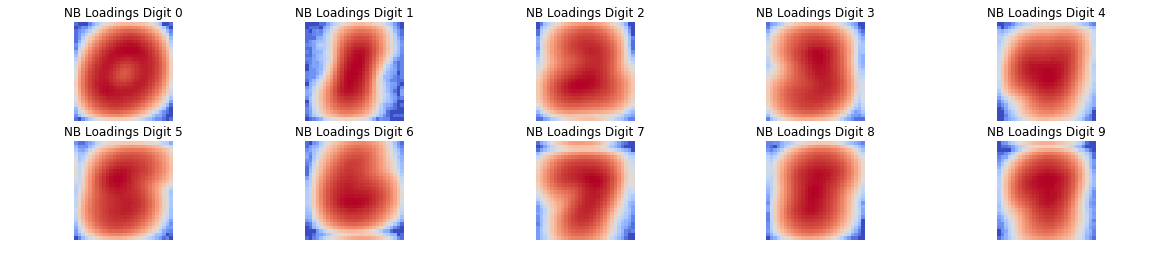

In [35]:
#  Two subplots, unpack the axes array immediately
f, axes = plt.subplots(2, 5, sharey=True,figsize=(20,4))
for d,ax in enumerate(axes.ravel()):
    ax.set_title('NB Loadings Digit {0}'.format(d))
    ax.imshow(loadings[d], cmap='coolwarm')
    ax.axis("off")

## Image Pre Processing

We have seem that Naive Bayes performance degrades if the test images are not well centered.

One solution to this problem, if the overall image location is not important is to **transform** images before training and testing so that they are always centered.

### Centering an Image

Let's pick one image and compute its center of mass

$$
    c_x = \frac{\sum_{r,c} r \, f_{r,c}}{\sum_{r,c} f_{r,c}}
$$
$$
    c_y = \frac{\sum_{r,c} c \,f_{r,c}}{\sum_{r,c} f_{r,c}}
$$
if the image is well centered we would like that
$$
    c_x = \frac{R}{2}
$$
and
$$
    c_y = \frac{C}{2}
$$

In [36]:
idx=24

In [37]:
center=ndimage.measurements.center_of_mass(shifted_images[idx])
center

(15.686453022578295, 14.787327021121632)

Let's compute how much we need to shift so that the center of mass is the center of the image

In [38]:
shift_x= int(round(nrows/2-center[0]))
shift_y=int(round(ncols/2-center[1]))
print(shift_x,shift_y)

-2 -1


Let's  shift the image. 
Now the center of mass is within half a pixel of the center of the image

In [39]:
centered_image=np.roll(shifted_images[idx],(shift_x,shift_y),(0,1))
center1=ndimage.measurements.center_of_mass(centered_image)
center1

(13.686453022578293, 13.78732702112163)

Let's observe our work

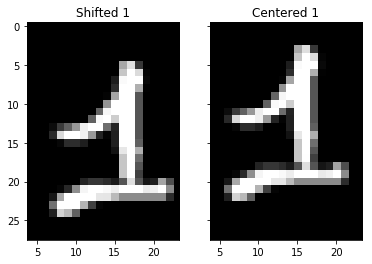

In [40]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
label=shifted_Y[idx]
ax1.set_title('Shifted {0}'.format(label))
ax1.imshow(shifted_images[idx], cmap='gray')
ax2.set_title('Centered {0}'.format(label))
ax2.imshow(centered_image, cmap='gray')

### A Centering Image Classifier

Let's create an Image Classifier that  centers images and then fits/predicts them

In [41]:
class ImageCenteredClassifier:
    def __init__(self, base_model):
        self.model=base_model
    def transform(self,X):
        N,nrows,ncols=X.shape
        centered_images=np.empty_like(X)
        for i1 in range(N):
            image=X[i1]
            center=ndimage.measurements.center_of_mass(image)
            shift_x= int(np.round(nrows/2-center[0]))
            shift_y= int(np.round(ncols/2-center[1]))
            centered_image=np.roll(image,(shift_x,shift_y),(0,1))
            centered_images[i1]=centered_image
        return centered_images.reshape(-1,nrows*ncols)
    def fit(self,X,Y):
        Xt=self.transform(X)
        self.model.fit(Xt,Y)
        return self
    def predict(self,X):
        Xt=self.transform(X)
        return self.model.predict(Xt)
        

#### Train Classifier

In [42]:
centered_model=ImageCenteredClassifier(ber_model)

In [43]:
centered_model.fit(shifted_images,shifted_Y)

#### Evaluate Classifier

In [44]:
Y_pred=centered_model.predict(shifted_images_test)

Results are now as good as the initial *MNIST* inputs

In [45]:
np.mean(Y_pred==Y_test)

0.83760000000000001

1. **MNIST** image set is already **centered**, it has been pre-processed.
2. In general centering an image can help with classification, particularly for naive classifiers that look at each pixel in isolation
3. Sometimes, a rotation, a scaling, or, a normalization of the color/gray scale may also be used in a **pre-processing** step.
4. The apropiate level of pre-processing is **problem dependent**.